# Chapter 11, Example 2

## Import packages

In [1]:
# TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt

## Prepare training data

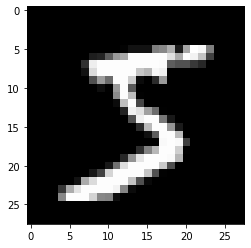

In [2]:
# Generate uniform noise (inputs for generator)
def sample_z(num_sample, num_dim):
    z = np.random.uniform(-1, 1, size=[num_sample, num_dim])
    return tf.constant(z, dtype=tf.float32)

# MNIST, our training dataset
batch_size = 128
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images / 255.0  # normalize to [0, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)

# Show one image as an example
plt.imshow(train_images[0, :, :, :], cmap='gray')

## Define the generator and discriminator

In [3]:
def make_generator(noise_dim, hidden_dim, data_dim):
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(hidden_dim, use_bias=True, input_shape=(noise_dim,), activation='relu'))
    generator.add(layers.Dense(data_dim, use_bias=True, input_shape=(hidden_dim,), activation='sigmoid'))

    return generator

def make_discriminator(data_dim, hidden_dim):
    discriminator = tf.keras.Sequential()
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(hidden_dim, use_bias=True, input_shape=(data_dim,), activation='relu'))
    discriminator.add(layers.Dense(1, use_bias=True, input_shape=(hidden_dim,)))

    return discriminator

## Define the loss functions

This part is identical to the one in eg11.1.

In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_prediction, fake_prediction):
    real_loss = cross_entropy(tf.ones_like(real_prediction), real_prediction)
    fake_loss = cross_entropy(tf.zeros_like(fake_prediction), fake_prediction)
    return real_loss + fake_loss

def generator_loss(fake_prediction):
    return cross_entropy(tf.ones_like(fake_prediction), fake_prediction)

## Utility functions

In [5]:
def generate_and_save_images(generator, epoch, noise):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = generator(noise, training=False)
  predictions = tf.reshape(predictions, [predictions.shape[0], 28, 28])

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(predictions[i, :, :] * 255.0, cmap='gray')
      plt.axis('off')

  plt.savefig('./eg11.2/ep{:04d}.png'.format(epoch))
  plt.close()

## Define the training iterations

This part is identical to the one in eg11.1.

For more details, please refer to https://www.tensorflow.org/tutorials/generative/dcgan

In [6]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_sample, noise):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Compute the outputs
        fake_sample = generator(noise, training=True)
        real_prediction = discriminator(real_sample, training=True)
        fake_prediction = discriminator(fake_sample, training=True)

        # Update the discriminator
        loss_disc = discriminator_loss(real_prediction, fake_prediction)
        grad_disc = disc_tape.gradient(loss_disc, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

        # Update the generator
        loss_gen = generator_loss(fake_prediction)
        grad_gen = gen_tape.gradient(loss_gen, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

    return loss_gen, loss_disc

## Start training!

Please make sure you have run the above cell before you start your training. If you want to start another training, you need to re-run the above cell as well.

epoch: 20, loss_disc: 0.5654, loss_gen: 2.9741
epoch: 40, loss_disc: 0.5671, loss_gen: 2.5008
epoch: 60, loss_disc: 0.9115, loss_gen: 1.7556
epoch: 80, loss_disc: 0.8630, loss_gen: 2.1665
epoch: 100, loss_disc: 0.7601, loss_gen: 1.9451
epoch: 120, loss_disc: 0.8540, loss_gen: 1.6956
epoch: 140, loss_disc: 0.7838, loss_gen: 1.9070
epoch: 160, loss_disc: 0.7633, loss_gen: 1.9551
epoch: 180, loss_disc: 1.0327, loss_gen: 1.7435
epoch: 200, loss_disc: 0.7424, loss_gen: 1.5836
epoch: 220, loss_disc: 0.8538, loss_gen: 1.9879
epoch: 240, loss_disc: 0.8411, loss_gen: 1.7120
epoch: 260, loss_disc: 0.9220, loss_gen: 1.7898
epoch: 280, loss_disc: 0.6029, loss_gen: 1.8550
epoch: 300, loss_disc: 0.7681, loss_gen: 1.7113
epoch: 320, loss_disc: 0.7890, loss_gen: 1.7175
epoch: 340, loss_disc: 0.7116, loss_gen: 1.7466
epoch: 360, loss_disc: 0.7252, loss_gen: 1.9146
epoch: 380, loss_disc: 0.6179, loss_gen: 2.1615
epoch: 400, loss_disc: 0.5567, loss_gen: 2.1706
epoch: 420, loss_disc: 0.5933, loss_gen: 2.4

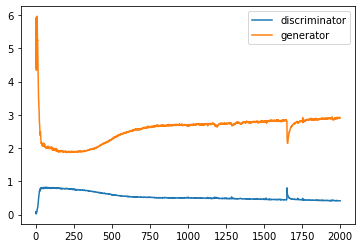

In [7]:
# Create the folder to store images
if not os.path.exists('eg11.2/'):
    os.makedirs('eg11.2/')

num_epoch = 2000

noise_dim = 100
g_dim = 256
data_dim = 784  # 28x28=784
d_dim = 128

# Set random seed for reproducibility
seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)

# Initialize generator and discriminator
generator = make_generator(noise_dim, g_dim, data_dim)
discriminator = make_discriminator(data_dim, d_dim)

# Adam optimizer
lr = 1e-3
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

# Generate examples before training
generate_and_save_images(generator, 0, sample_z(16, 100))

# Training iteration
genloss_l = []
discloss_l = []
for ep in range(1, num_epoch + 1):
    ep_genloss_l = []
    ep_discloss_l = []
    for image_batch in train_dataset:
        noise = sample_z(batch_size, noise_dim)  
        loss_gen, loss_disc = train_step(image_batch, noise)
        ep_genloss_l.append(loss_gen)
        ep_discloss_l.append(loss_disc)
    ep_genloss = np.mean(ep_genloss_l)
    ep_discloss = np.mean(ep_discloss_l)
    genloss_l.append(ep_genloss)
    discloss_l.append(ep_discloss)

    if ep % 20 == 0:
        print(f'epoch: {ep}, loss_disc: {loss_disc:.4f}, loss_gen: {loss_gen:.4f}')
        generate_and_save_images(generator, ep, sample_z(16, 100))

# Plot the training curves
print('----Training Curves----')
plt.plot(range(len(genloss_l)), discloss_l, label='discriminator')
plt.plot(range(len(genloss_l)), genloss_l, label='generator')
plt.legend()
plt.savefig('eg11.2/training_curve.png')
plt.show()
